<a href="https://colab.research.google.com/github/Hoggnation/cataloging_coherent_oscillators/blob/main/Filtering_Function_on_TIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightkurve
!apt-get install -y build-essential
!apt-get install -y libatlas-base-dev
!apt-get install -y gfortran
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install pymc
import numpy as np
print(np.__version__)
import pymc as pm
import arviz as az
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

Reading package lists... Done
Building dependency tree... Done

build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libatlas-base-dev is already the newest version (3.10.3-12ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gfortran is already the newest version (4:11.2.0-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
1.26.4


In [ ]:
#this means only look at top hundred frequencies/peaks
num_of_peaks = 100

In [ ]:
search_result = lk.search_lightcurve('TIC 410038602', mission='TESS')
lc_collection = search_result.download_all()

In [ ]:
#array of time differences, find its median, use it to calculate the max frequency
lc = lc_collection.stitch()  # Combine all light curves in lc_collection
sampling_rate_days = np.median(np.diff(lc.time))
sampling_rate_days_no_units = sampling_rate_days.value #get rid of units
f_max = 1 / (2 * sampling_rate_days) #in days
f_max_no_units = f_max.value #get rid of units (but it's actually in 1/days)

print(sampling_rate_days)
print(f_max)

print(sampling_rate_days_no_units)
print(f_max_no_units)


/usr/local/lib/python3.11/dist-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_flux', 'sap_bkg', 'sap_bkg_err'}
  warnings.warn(


0.0023147686422362312
216.00430854159336 1 / d
0.0023147686422362312
216.00430854159336


In [ ]:
#check there is no unit
print(type(f_max_no_units), type(sampling_rate_days_no_units))

<class 'numpy.float64'> <class 'numpy.float64'>


In [ ]:
#find total observation time, use it to find minimum frequency
total_observation_time = lc.time[-1] - lc.time[0] # in days
f_min = f_min = 1/ total_observation_time # in days
f_min_no_units = f_min.value #strip units (but are in 1/days)
print(f_min_no_units)
print(type(f_min_no_units))

0.040578475585956036
<class 'numpy.float64'>


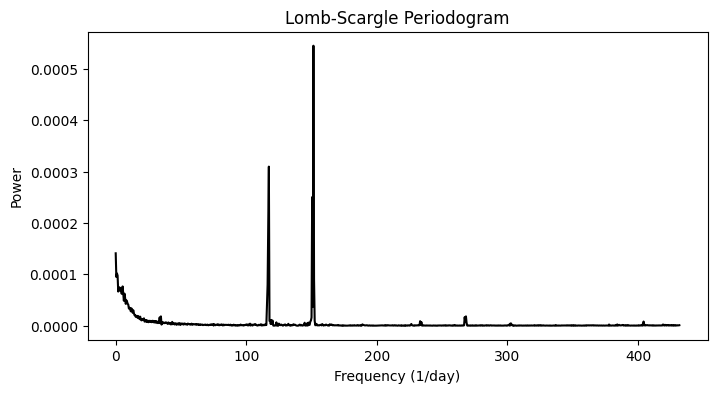

In [ ]:
#trying to create periodograms with no units by manually plotting
#use lightcurve called lc to make periogram pg
pg = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    minimum_frequency=f_min_no_units,
    maximum_frequency=f_max_no_units
)

power_no_units = np.array(pg.power.value) # an array of powers of the ligthcurve
freq_no_units = np.array(pg.frequency.value) # array of freqs of lightcurve
plt.figure(figsize=(8, 4))
plt.plot(freq_no_units, power_no_units, 'k-')  # Black line
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.show()

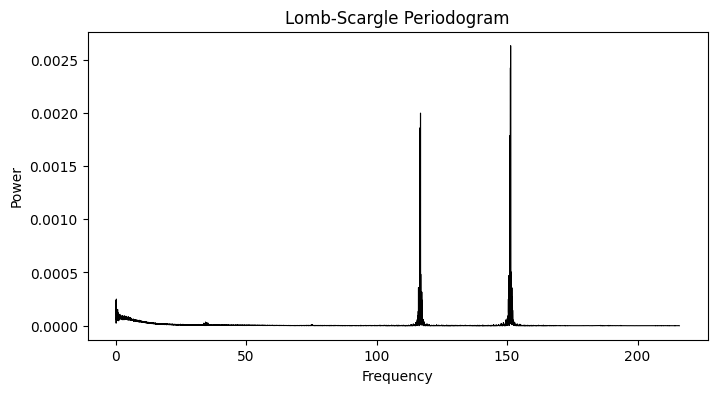

[4.05784756e-02 8.11569512e-02 1.21735427e-01 ... 2.15918069e+02
 2.15958647e+02 2.15999226e+02]
[1.41004074e-04 2.35686308e-04 6.33087817e-05 ... 8.22502324e-07
 4.91038186e-07 8.00513868e-08]


In [ ]:
#trying to create periodograms of spacing f_min
frequency_grid = np.arange(f_min_no_units, f_max_no_units, f_min_no_units) #spacing with increments of f_min, starting with f_min_no_units to avoid di

#create periodogram only to get values in order to remove units
pg_spacing_fmin = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid  # Unitless frequency grid
)

freq_values = np.array(pg_spacing_fmin.frequency.value)  # Remove units
power_values = np.array(pg_spacing_fmin.power.value)  # Remove units

plt.close('all')

plt.figure(figsize=(8, 4))
plt.plot(freq_values, power_values, 'k-', lw=0.8)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")

plt.show()

print(freq_values)
print(power_values)

In [ ]:
def get_started(num_of_peaks, xs, ys):
    """

    Identifies and returns the indices of the highest peaks in a given dataset.

    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array


    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

In [ ]:
indices = get_started(num_of_peaks, freq_values, power_values)
print(indices)

[3729 3727 2878 2873 3722 3724 2871 2876 3731 2880 3710 3734 2859 3741
 2890 3720 3743    6 3708 2892    1 3746 2883 2868 2861 3712 6601   18
 3748 2857   21   10   39   24   13 3715   27 6603   66   51 3705   83
   37 2854 2895 6606   97   15   35   63   69   85   49  102  100   54
   88 2888  119 3739   80   58   72   75  114  116  133   44   61  136
   32   30  131    3  105   46  111 2866   78  148   94   92 3698  124
  128  122  150  145  108  141  167 6608 3717  153  165  138 2902  155
  160 2897]


In [ ]:
def reorder_inputs(xs,ys):
    """

    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values

    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length

    """
    i = np.argsort(xs)
    return xs[i], ys[i]


In [ ]:
#xlist is the teh index left to highest peak, highest peak, and the index right to the highest peak
def design_matrix(xlist):
    """

    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered

    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

In [ ]:
def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak


    Returns:
        tuple: (b, m, q)

    Bugs:
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array


    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

In [ ]:
def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak

    Returns:
        tuple: (x position of refined peak, y position of refined peak)

    Bugs:
        Must be synchronized with the design matrix


    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b

In [ ]:
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        tuple of numpy arrays (array of refined x positions, array of refined y positions


    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined)

In [ ]:
new_positions = refine_peaks(freq_values, power_values, indices) # this returns the new x values
#and the new y values

In [ ]:
print (new_positions)

(array([1.51356627e+02, 1.51277584e+02, 1.16825006e+02, 1.16621348e+02,
       1.51074487e+02, 1.51155099e+02, 1.16543051e+02, 1.16743533e+02,
       1.51449423e+02, 1.16907390e+02, 1.50584078e+02, 1.51559724e+02,
       1.16053111e+02, 1.51846431e+02, 1.17315028e+02, 1.50991247e+02,
       1.51926449e+02, 2.85896552e-01, 1.50507477e+02, 1.17392434e+02,
       7.52542338e-02, 1.52047724e+02, 1.17027471e+02, 1.16431293e+02,
       1.16134063e+02, 1.50676891e+02, 2.67899805e+02, 7.76280465e-01,
       1.52129406e+02, 1.15974065e+02, 8.98882114e-01, 4.45012550e-01,
       1.61846191e+00, 1.01351187e+00, 5.65105075e-01, 1.50785162e+02,
       1.12713352e+00, 2.67979492e+02, 2.72484099e+00, 2.12255020e+00,
       1.50384242e+02, 3.40878210e+00, 1.55669897e+00, 1.15851483e+02,
       1.17512588e+02, 2.68103530e+02, 3.97733062e+00, 6.56956123e-01,
       1.45268052e+00, 2.60300968e+00, 2.82731602e+00, 3.49436727e+00,
       2.02591730e+00, 4.18613253e+00, 4.08958348e+00, 2.23053908e+00,
     

In [ ]:
#originally the new positions function was returning the refined peaks and powers as seperate arrays, now they are arranged as tuples so that the zip function works
new_frequencies, new_powers = refine_peaks(freq_values, power_values, indices)
new_positions = list(zip(new_frequencies, new_powers))
refined_frequencies, refined_powers = zip(*new_positions)

In [ ]:
refined_frequencies, refined_powers = zip(*new_positions)


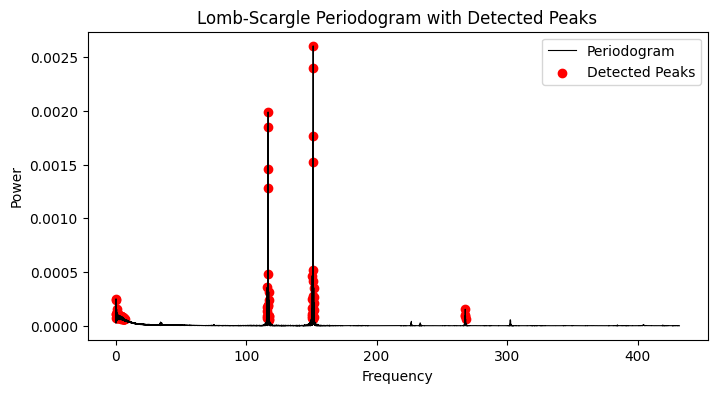

In [ ]:
plt.figure(figsize=(8, 4))

plt.plot(freq_values, power_values, 'k-', lw=0.8, label="Periodogram")

plt.scatter(refined_frequencies, refined_powers, color='red', marker='o', label="Detected Peaks")

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram with Detected Peaks")
plt.legend()

plt.show()

Frequency range: 0.07525423384063173 to 268.1806424076268
Amplitude range: 5.770362184875921e-05 to 0.002606173358799424
Frequency range: 0.040578475585956036 to 215.99922554404398
Amplitude range: 1.7451643313603775e-10 to 0.002630049350028188
Best-fit parameters: A = 0.003145646615612495, mu = 7.365063823787674, sigma = -0.007168468986157462
Chi-squared: 0.05793229861230191


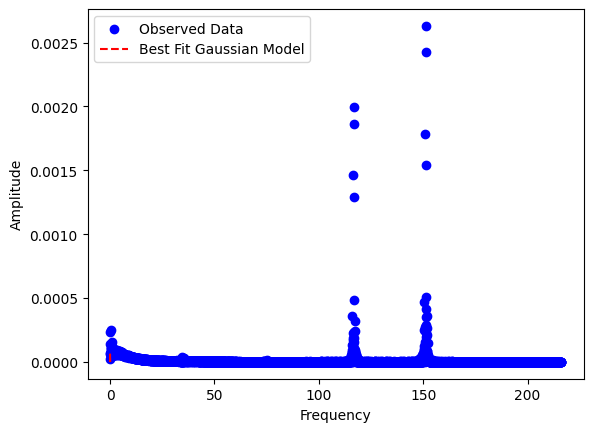

In [ ]:
from scipy.optimize import minimize

# Refined data for our expected model
ref_frequencies = np.array(refined_frequencies)
ref_powers = np.array(refined_powers)

# Observed data to compare with our model
observed_frequencies = np.array(pg_spacing_fmin.frequency.value)
observed_powers = np.array(pg_spacing_fmin.power.value)

print("Frequency range:", np.min(ref_frequencies), "to", np.max(ref_frequencies))
print("Amplitude range:", np.min(ref_powers), "to", np.max(ref_powers))

print("Frequency range:", np.min(observed_frequencies), "to", np.max(observed_frequencies))
print("Amplitude range:", np.min(observed_powers), "to", np.max(observed_powers))

# Defining the chi-squared function and selecting our intial parameters
# A is max power
# mu is mean frequency
# sigma is standard deviation

# Initial guesses for the parameters (A, mu, sigma) based on the refined data as defiend above
initial_guess = [np.max(ref_powers), np.median(ref_frequencies), np.std(ref_frequencies)]

def chi_squared(params):
    A, mu, sigma = params

    # This is our expected model
    model_predictions = A * np.exp(-0.5 * ((observed_frequencies - mu) ** 2) / sigma ** 2)

    # Using the chi-squared function to evaluate the error between our expected and observed values
    chi2 = np.sum(((observed_powers - model_predictions) ** 2) / observed_powers)
    return chi2

# Perform optimization to minimize chi-squared
# Not sure if this is the ideal method to use
result = minimize(chi_squared, initial_guess, method='Nelder-Mead')

# These are the new parameters (A, mu, sigma) after optimization
best_A, best_mu, best_sigma = result.x
print(f"Best-fit parameters: A = {best_A}, mu = {best_mu}, sigma = {best_sigma}")
print(f"Chi-squared: {result.fun}")

# Plot the observed data and the model predictions
plt.scatter(observed_frequencies, observed_powers, label="Observed Data", color='blue')

# Generate the model predictions using the best-fit parameters
new_model_predictions = best_A * np.exp(-0.5 * ((observed_frequencies - best_mu) ** 2) / best_sigma ** 2)
plt.plot(observed_frequencies, new_model_predictions, label="Best Fit Gaussian Model", color='red', linestyle='--')

plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# Something is clearly wrong :(

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x797742f1a2a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error
Exception ignored on calling ctypes callback function: <functio

Output()

 ^^ ^^^  ^ ^ ^ 
    File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
     self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD) 
               ^ ^^ ^  ^^  ^  ^^ ^^^^^^^^^^^^^
^  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
^    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)^
 ^ ^ ^ ^^  ^ ^  ^^  ^^  ^ ^^^  ^ ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    ^self._handle = _dlopen(self._name, mode)^
^ ^ ^ ^^ ^ ^ ^^ ^^^ ^^ ^ ^  ^^^^ ^ ^^ ^  ^ 
^  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
^    ^^self._handle = _dlopen(self._name, mode)^^^
^^ ^      ^ ^ ^    ^  ^  ^ ^ ^^^^^^^^^^^^^^^^^^^
^OSError^^^: ^^dlopen() error^
^^^^^^^
: dlopen() error


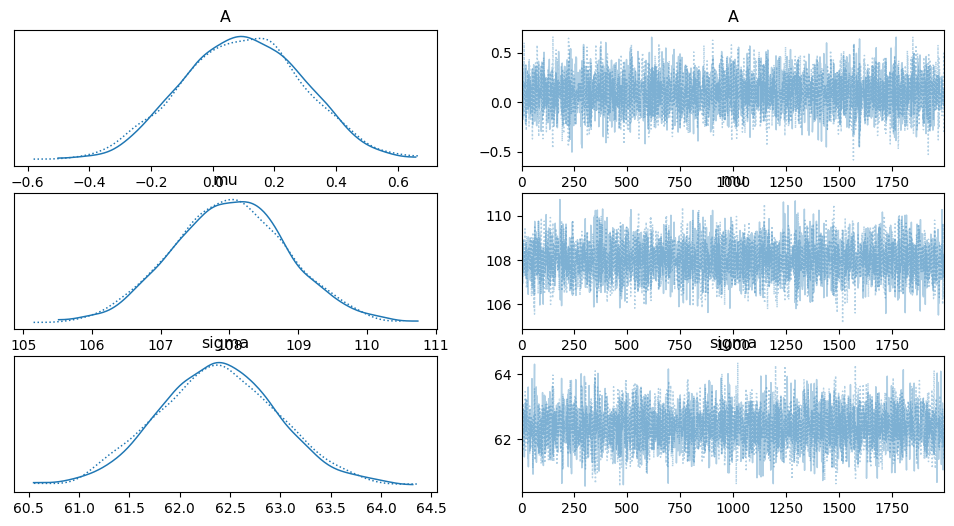

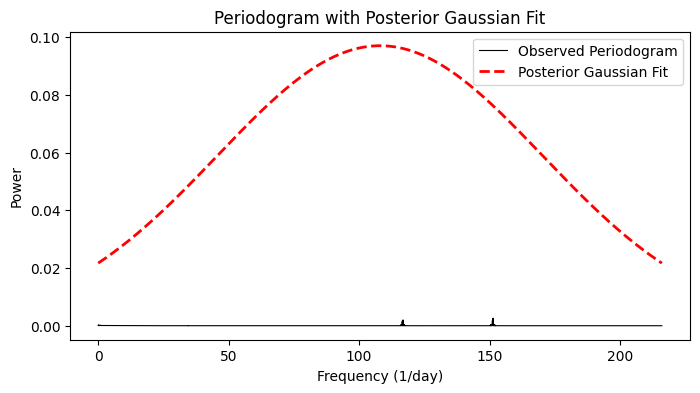

In [ ]:
# Refined data for our expected model
ref_frequencies = np.array(refined_frequencies)
ref_powers = np.array(refined_powers)
ref_powers /= np.max(ref_powers)

# Observed data from the periodogram (e.g., the frequencies and powers you already computed)
observed_frequencies = np.array(pg_spacing_fmin.frequency.value)
observed_powers = np.array(pg_spacing_fmin.power.value)

with pm.Model() as model:
    A = pm.Normal("A", mu=np.mean(ref_powers), sigma=np.std(ref_powers))
    mu = pm.Normal("mu", mu=np.mean(ref_frequencies), sigma=np.std(ref_frequencies))
    sigma = pm.HalfNormal("sigma", sigma=np.std(ref_frequencies))  # BROADER PRIOR

    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=observed_frequencies)

    trace = pm.sample(2000, tune=1000, cores=2)

az.plot_trace(trace)
plt.show()

# Extract mean posterior values
posterior_summary = az.summary(trace)
best_A = posterior_summary.loc["A", "mean"]
best_mu = posterior_summary.loc["mu", "mean"]
best_sigma = posterior_summary.loc["sigma", "mean"]

# Generate model predictions using posterior values
model_frequencies = np.linspace(np.min(observed_frequencies), np.max(observed_frequencies), 1000)
model_curve = best_A * np.exp(-0.5 * ((model_frequencies - best_mu) ** 2) / best_sigma ** 2)

# Plot observed periodogram
plt.figure(figsize=(8, 4))
plt.plot(observed_frequencies, observed_powers, 'k-', lw=0.8, label="Observed Periodogram")

# Overlay the new posterior-based Gaussian curve
plt.plot(model_frequencies, model_curve, 'r--', lw=2, label="Posterior Gaussian Fit")

# Labels and legend
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Periodogram with Posterior Gaussian Fit")
plt.legend()
plt.show()


In [ ]:
print(f"Best A: {best_A}, Best mu: {best_mu}, Best sigma: {best_sigma}")

Best A: 0.097, Best mu: 108.008, Best sigma: 62.379


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x79775115bba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error
Exception ignored on calling ctypes callback function: <functio

Output()

lib_controller = controller_class(    self._make_controller_from_path(filepath)
 
    File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
         lib_controller = controller_class( 
                      ^ ^^  ^ ^ ^^ ^ ^^^^ ^^ ^^ ^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
 ^^^^    ^^^^^^^^^^self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)^
   ^ 
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
      self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD) 
                       ^^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
^    ^self._handle = _dlopen(self._name, mode)^
^ ^ ^ ^ 
   File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
      self._handle = _dlopen(self._name, mode) 
             ^ ^ ^ ^^ ^    ^^ ^^^^^^^^^^^^^^

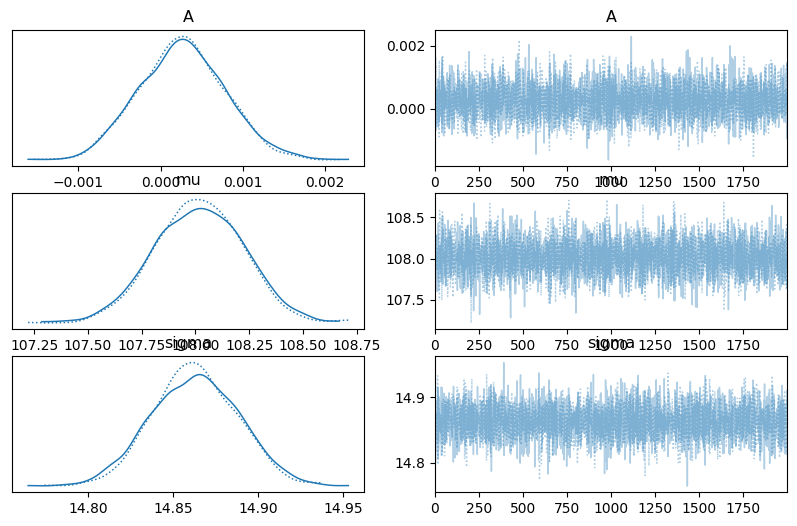

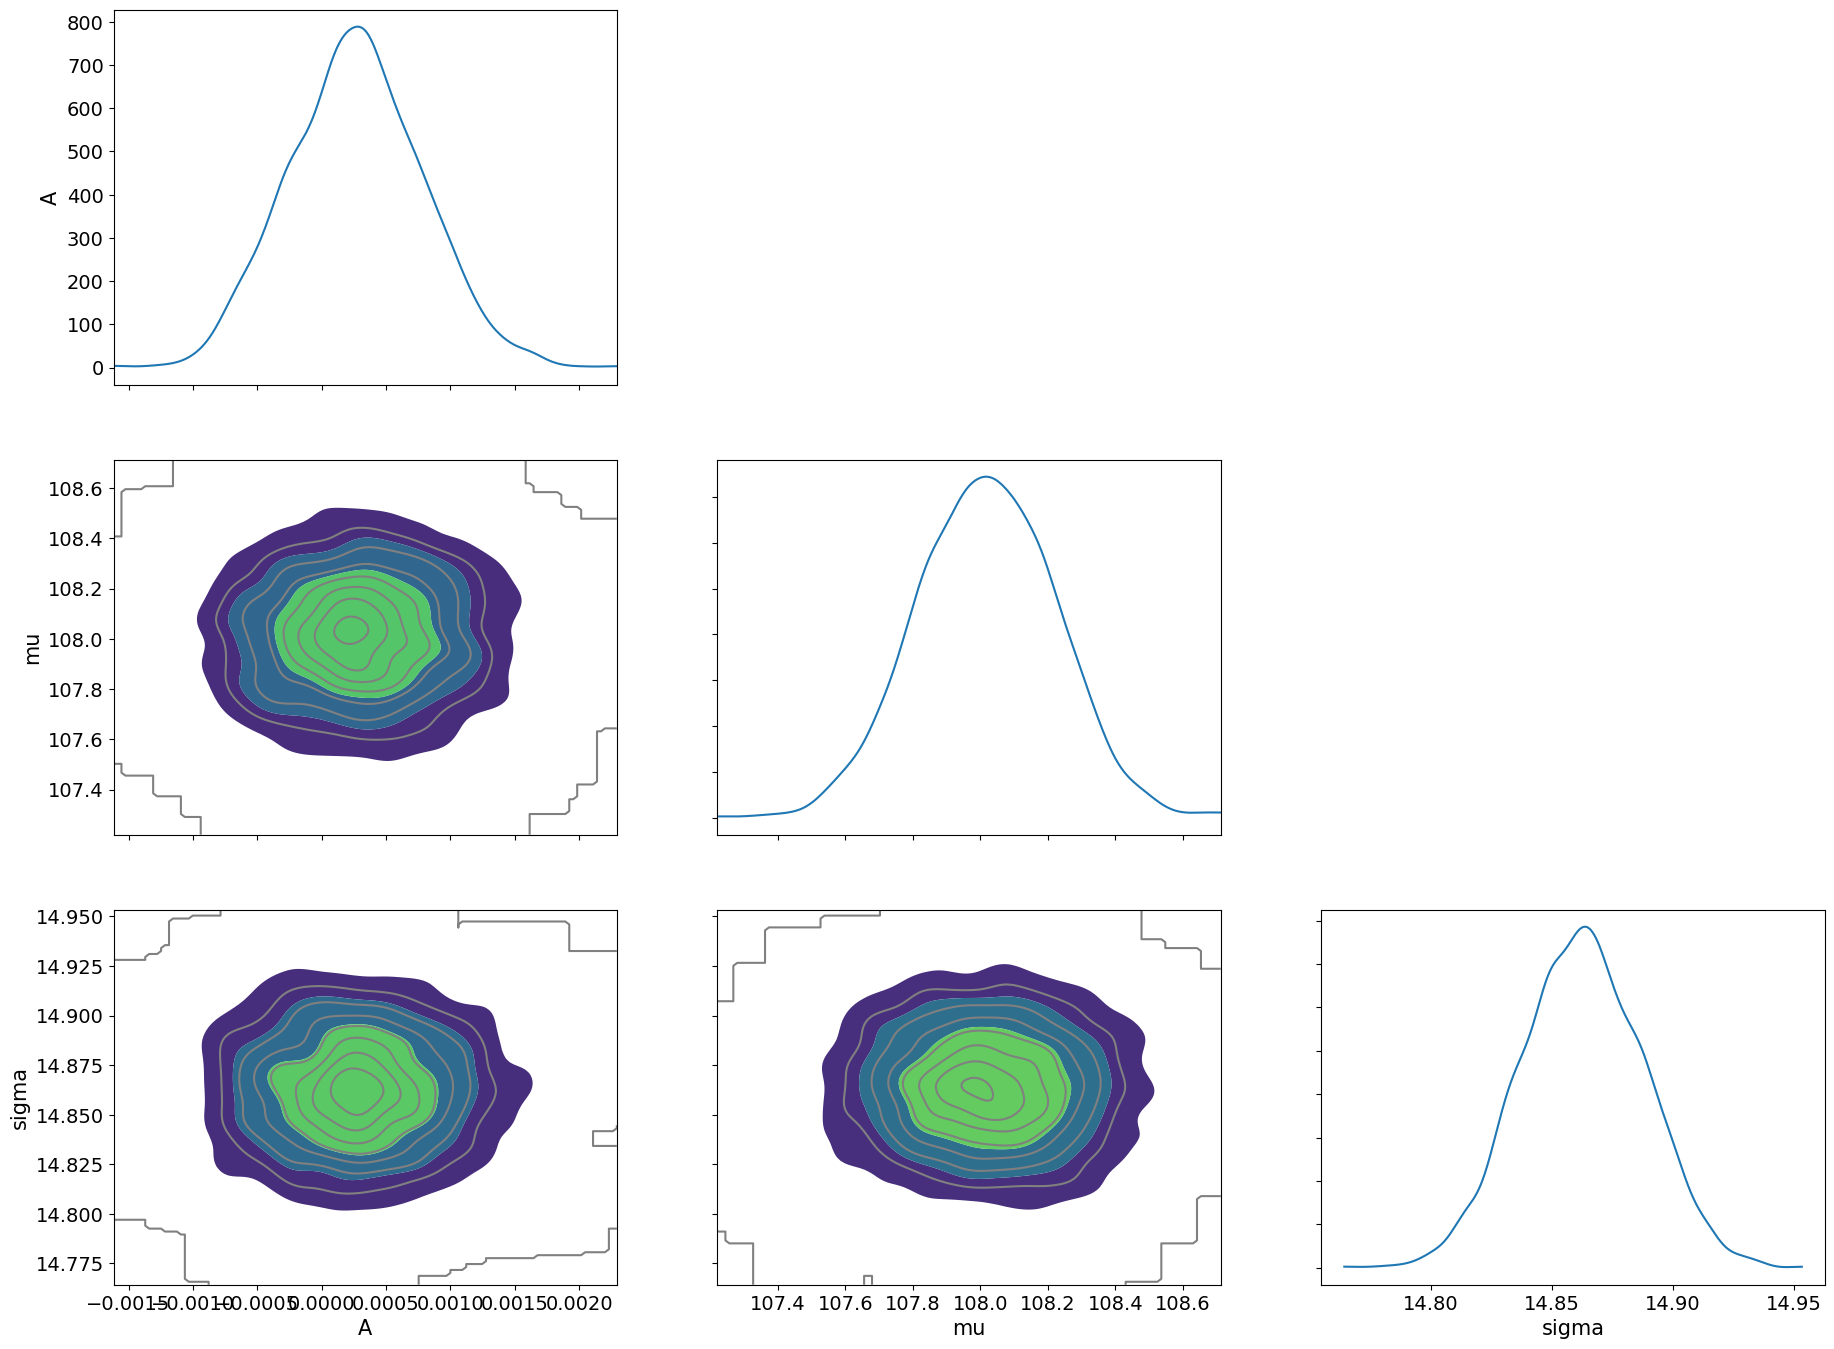

In [ ]:
from scipy.optimize import minimize

# Trying to define our prior
# Turning refined_peaks and refined_frequencies back into arrays because they were in tuples so that they could be zipped

ref_frequencies = np.array(refined_frequencies)
ref_powers = np.array(refined_powers)

freq_values = np.array(pg_spacing_fmin.frequency.value)  # Remove units
power_values = np.array(pg_spacing_fmin.power.value)  # Remove units

observed_frequencies = np.array(pg_spacing_fmin.frequency.value)
observed_powers = np.array(pg_spacing_fmin.power.value)

with pm.Model() as model:

    # For our priors we assume normal Gaussian distribution around each refined peak and frequency
    # Not sure what to select for sigma(uncertainity)

    A = pm.Normal("A", mu=np.mean(ref_powers), sigma=np.std(ref_powers))
    mu = pm.Normal("mu", mu=np.mean(ref_frequencies), sigma=np.std(ref_frequencies))
    sigma = pm.HalfNormal("sigma", sigma=0.05)  # Spread prior (ensuring positivity)

    # Our likelihood assumes that our observed frequencies fall within a Gaussian distribution
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=observed_frequencies)

    # Sample from the posterior using MCMC
    trace = pm.sample(2000, tune=1000, cores=2)

    # Plot posterior distributions using ArviZ
    az.plot_trace(trace, figsize=(10, 6))
    plt.show()

    # Corner plot to see parameter correlations
    az.plot_pair(trace, kind="kde", marginals=True)
    plt.show()
